In [29]:
from pathlib import Path
import dataclasses
import itertools
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sklearn
import torch
import safetensors
import IPython.display as ipy_display
sns.set_style('darkgrid')
import subprocess
import shutil                # ← to delete old mmseqs2 files/folders
from sklearn.model_selection import train_test_split
import numpy as np
from sys import platform
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics.pairwise import cosine_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from sklearn.ensemble   import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost            import XGBClassifier
from ngboost            import NGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import scipy
import math
from collections import namedtuple
from itertools import combinations

# Utility Functions

In [61]:
from __future__ import annotations

from typing import Sequence
from torch import Tensor
from jaxtyping import Float, Integer
from enum import StrEnum, auto

StringArray = Sequence[str]
Array = Tensor | np.ndarray
ArrayInt = Integer[Array, 'n']
DiscreteArray = ArrayInt | StringArray

@dataclasses.dataclass
class SplitTuple:
    train : Sequence[int]
    val: Sequence[int]
    test: Sequence[int]
    
    def __post_init__(self):
        """Raises error if split parts overlap."""
        for a, b in [('train', 'val'), ('val', 'test'), ('test', 'train')]:
            overlap = np.intersect1d(getattr(self, a), getattr(self, b))
            if overlap.shape[0]:
                raise ValueError(
                    f'Found {len(overlap)} overlapping items between {a} and {b}.'
                )
    
    def __len__(self) -> int:
        return len(self.train) + len(self.val) + len(self.test)

    def trainval(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val], axis=0)

    def indices(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val, self.test], axis=0)

    def as_dict(self) -> dict[str, DiscreteArray]:
        return dataclasses.asdict(self)
    
    @classmethod
    def from_lists(
        cls,
        train: DiscreteArray,
        val: DiscreteArray,
        test: DiscreteArray
    ) -> 'SplitTuple':
        return cls(
            train=np.asarray(train),
            val=np.asarray(val),
            test=np.asarray(test)
        )
        
def load_embeddings(file):
    tensors = {}
    with safetensors.safe_open(str(file), framework='pt') as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k).numpy()
    return tensors
    
class ArrayMap:
    """Map discrete values (sequences, int, smiles) to arrays."""

    def __init__(self, keys, values):

        self.mapper = pd.Series(data=np.arange(len(keys)), index=keys)
        self.values = values
        # Check for duplicates.
        dups = self.mapper.index[self.mapper.index.duplicated()].tolist()
        if dups:
            raise ValueError(f'Found {len(dups)} duplicated isosmiles={dups}')
    
    @classmethod
    def from_dict(cls, adict) -> ArrayMap:
        return ArrayMap(np.array(list(adict.keys())), np.stack(list(adict.values())))

    @classmethod
    def load(cls, fname: str) -> ArrayMap:
        data = load_embeddings(fname)
        return cls.from_dict(data)

    @property
    def keys(self):
        return list(self.mapper.index)
        

    def __call__(self, key_array: types.DiscreteArray):
        assert isinstance(key_array, np.ndarray), 'expected np.ndarray as input!'
        return self.values[self.mapper[key_array].values]
        
def html_header(text:str, n:int = 2)-> None:
    ipy_display.display(ipy_display.HTML(f'<h{n}>{text}</h{n}>'))

    
def peek_df(df:pd.DataFrame, title:str=None, n=5)-> None:
    if title:
        if is_notebook():
            html_header(f'{title:-^30}')
        else:
            print(f'{title:-^30}')
        
    print(f'Columns: {df.columns}')
    print(f'Shape: {df.shape}')
    if n > 0 and is_notebook():
        ipy_display.display(df.head(n=n))

def evaluate(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    pearson_r, _ = scipy.stats.pearsonr(y_true, y_pred)
    r_squared = sklearn.metrics.r2_score(y_true, y_pred)
    kendall_tau, _ = scipy.stats.kendalltau(y_true, y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    return {'pearson_r': pearson_r, 'R^2': r_squared, 'kendall_tau': kendall_tau, 'mae': mae}

def divide_per_cluster(
    df_complete: pd.DataFrame,
    col_prot: str,
    col_sequence: str,
    # Optional directory output
    directory_out: Path = None, 
    tresh_identity: float = 0.8,
    n_splits: int = 10,
    frac_val: float = 0.1,
    frac_test: float = 0.1,
    seed: int = 42
) -> dict:
    """
    Divides a dataframe based on protein clusters using MMseqs2.
    """
    print("Initiating splittting of data based on protein clusters...")

    # --- Part A: Clustering with MMseqs2 ---
    df_unique = df_complete[[col_prot, col_sequence]].drop_duplicates().reset_index(drop=True)
    print(f"Found {len(df_unique)} sequences for clustering.")
    
    base_temp_path = directory_out if directory_out is not None else Path("./")
    dir_mmseqs = base_temp_path / "mmseqs_temp"
    dir_mmseqs.mkdir(parents=True, exist_ok=True)

    fasta_path = dir_mmseqs / "sequences.fasta"
    db_path = dir_mmseqs / "DB"
    cluster_path = dir_mmseqs / "ClusterDB"
    results_tsv_path = dir_mmseqs / "clusters.tsv"

    with open(fasta_path, "w") as f:
        for _, row in df_unique.iterrows():
            f.write(f">{row[col_prot]}\n{row[col_sequence]}\n")

    try:
        subprocess.run(["mmseqs", "createdb", str(fasta_path), str(db_path)], check=True, capture_output=True, text=True)
        subprocess.run([
            "mmseqs", "cluster", str(db_path), str(cluster_path), str(dir_mmseqs / "tmp"),
            "--min-seq-id", str(tresh_identity)
        ], check=True, capture_output=True, text=True)
        subprocess.run(
            ["mmseqs", "createtsv", str(db_path), str(db_path), str(cluster_path), str(results_tsv_path)],
            check=True, capture_output=True, text=True
        )
    except FileNotFoundError:
        raise SystemExit("ERROR: Couldn't find MMseqs2. Please make sure it is installed and available in your PATH.")
    except subprocess.CalledProcessError as e:
        raise SystemExit(f"ERROR: MMseqs2 Failed.\nOutput error:\n{e.stderr}")

    df_clusters = pd.read_csv(results_tsv_path, sep="\t", header=None, names=['cluster_id', col_prot])
    map_cluster = df_clusters.set_index(col_prot)['cluster_id'].to_dict()
    df_complete['cluster_id'] = df_complete[col_prot].map(map_cluster)
    
    print(f"Clustering done. Identified {df_complete['cluster_id'].nunique()} clusters.")

    # Initialize dict
    split_dict_generado = {}
    ids_de_clusters = df_complete['cluster_id'].unique()
    
    # Splits loop
    for i in range(n_splits):
        current_seed = seed + i # A seed for each split
        
        clusters_ent_val, clusters_test = train_test_split(
            ids_de_clusters, test_size=frac_test, random_state=current_seed
        )
        frac_val_ajustada = frac_val / (1 - frac_test) if (1 - frac_test) > 0 else 0
        clusters_train, clusters_val = train_test_split(
            clusters_ent_val, test_size=frac_val_ajustada, random_state=current_seed
        )

        # Obtain original datframa indexes
        indices_train = df_complete[df_complete['cluster_id'].isin(clusters_train)].index.to_numpy()
        indices_val = df_complete[df_complete['cluster_id'].isin(clusters_val)].index.to_numpy()
        indices_test = df_complete[df_complete['cluster_id'].isin(clusters_test)].index.to_numpy()

        # Creating split tuple instance and saving it
        split_key = f'Cluster_{i+1}'
        split_dict_generado[split_key] = SplitTuple(
            train=indices_train,
            val=indices_val,
            test=indices_test
        )
        print(f"  - Generated {split_key}: Train={len(indices_train)}, Val={len(indices_val)}, Test={len(indices_test)}")

    # --- Part C (Optional): Save and clean ---
    if directory_out:
        print("\nSaving splits to CSV files...")
        # Saving a full file with "split" column for the first split
        df_complete['split'] = 'sin_asignar'
        split_0 = list(split_dict_generado.values())[0] # First split as an example
        df_complete.loc[split_0.train, 'split'] = 'train'
        df_complete.loc[split_0.val, 'split'] = 'val'
        df_complete.loc[split_0.test, 'split'] = 'test'
        
        df_final = df_complete.drop(columns=['cluster_id', col_sequence])
        nombre_base = f"dataset_split_id{tresh_identity}"
        df_final.to_csv(directory_out / f"{nombre_base}_complete_example.csv", index=False)
        print(f"Saved example split file to {directory_out}")
    
    # Clean temporary MMseqs2 files
    temp_dir_for_mmseqs = directory_out / "mmseqs_temp" if directory_out else Path("./mmseqs_temp")
    if temp_dir_for_mmseqs.exists():
        shutil.rmtree(temp_dir_for_mmseqs)
    
    # Return dict
    print("\nDONE! Returning split dictionary.")
    return split_dict_generado

def generate_mls_splits(
    df_complete: pd.DataFrame,
    col_cluster: str,
    col_y: str,
    n_bins_y: int = 5,
    n_splits: int = 10,
    frac_test: float = 0.2,
    frac_val: float = 0.1,
    seed: int = 42
) -> dict:
    """
    Generates splits using Multilabel Stratification on cluster IDs and the target variable y,
    with precise control over test and validation fractions.
    """
    print(f"Generating {n_splits} splits (Test: {frac_test:.0%}, Val: {frac_val:.0%})...")

    # --- 1. Prepare labels for stratification (no changes here) ---
    # One-Hot-Encode cluster IDs
    cluster_ids = pd.factorize(df_complete[col_cluster])[0]
    n_clusters = len(np.unique(cluster_ids))
    cluster_one_hot = np.zeros((len(df_complete), n_clusters), dtype=bool)
    cluster_one_hot[np.arange(len(df_complete)), cluster_ids] = 1

    # Bin the continuous target variable 'y' into categories
    y_binned = pd.qcut(df_complete[col_y], q=n_bins_y, labels=False, duplicates='drop')
    y_one_hot = pd.get_dummies(y_binned).to_numpy(dtype=bool)

    # Create the "Super-Label" by combining cluster and y labels
    split_labels = np.hstack([cluster_one_hot, y_one_hot])
    print(f"Created stratification matrix with shape {split_labels.shape} (rows, clusters + y_bins)")
    
    # --- 2. Corrected Splitting Logic ---
    split_dict_generated = {}
    indices = np.arange(len(df_complete))
    
    # Main loop to create n_splits different splits
    for i in range(n_splits):
        current_seed = seed + i
        
        # --- STEP A: First split (trainval / test) ---
        # We use MultilabelStratifiedShuffleSplit to gain control over `frac_test`.
        first_splitter = MultilabelStratifiedShuffleSplit(
            n_splits=1, # We only want one split from this
            test_size=frac_test, 
            random_state=current_seed
        )
        # Get the first (and only) split's indices
        trainval_idx, test_idx = next(first_splitter.split(indices, split_labels))

        # --- STEP B: Second split (train / val) from the trainval set ---
        relative_val_size = frac_val / (1.0 - frac_test) if (1.0 - frac_test) > 0 else 0
        
        second_splitter = MultilabelStratifiedShuffleSplit(
            n_splits=1,
            test_size=relative_val_size,
            random_state=current_seed
        )
        train_idx_rel, val_idx_rel = next(second_splitter.split(trainval_idx, split_labels[trainval_idx]))

        train_idx = trainval_idx[train_idx_rel]
        val_idx = trainval_idx[val_idx_rel]
        
        split_key = f'Stratified_{i+1}'
        split_dict_generated[split_key] = SplitTuple(
            train=train_idx,
            val=val_idx,
            test=test_idx
        )
        print(f"  - Generated {split_key}: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")
        
    print("\nDONE! Returning Multilabel Stratified split dictionary.")
    return split_dict_generated

def loco_balanced(
    df: pd.DataFrame,
    *,
    col_cluster: str,                 # p.ej. 'embedding_cluster_id'
    col_y: str | None = None,         # continuo o binario (solo si ensure_both_classes=True)
    n_splits: int = 0,                # <-- ignorados (compatibilidad)
    frac_test: float = 0.0,           # <-- ignorados
    frac_val: float = 0.0,            # <-- ignorados
    random_state: int = 0,            # <-- semilla solo si añades aleatoriedad
    n_bins_y: int = 5,                # <-- ignorado
    # ---- parámetros de evaluación por clúster ----
    target_clusters: list[int] | None = None,  # p.ej. [4, 5]
    col_protein: str | None = None,            # columna con el nombre de proteína
    max_pairs_per_cluster: int | None = None,  # None = todas las parejas
    ensure_both_classes: bool = False,         # exigir ambas clases en test/val
    threshold: float = -1.5,                   # si col_y es continuo
    emit_baseline_variants: bool = False       # variantes _BASE (val vacío; train+=val)
) -> dict[str, SplitTuple]:
    """
    SOLO modo intra-clúster: para cada clúster en target_clusters,
    empareja proteínas y crea splits (test=protA, val=protB) y el inverso.
    """
    assert target_clusters is not None, "Debes pasar target_clusters=[...]"
    assert col_protein is not None, "Debes pasar col_protein=nombre_columna_de_proteína"

    all_idx = df.index.to_numpy()
    splits: dict[str, SplitTuple] = {}

    # Preparar etiqueta binaria si se exige doble clase
    if ensure_both_classes:
        assert col_y is not None, "col_y requerido si ensure_both_classes=True"
        y_series = df[col_y]
        if y_series.dropna().nunique() == 2:
            ybin = (y_series.astype(int) > 0).to_numpy()
        else:
            ybin = (y_series.to_numpy() > threshold)

        def both_classes(ix: np.ndarray) -> bool:
            if ix.size == 0: 
                return False
            u = np.unique(ybin[ix])
            return u.size == 2

    for cid in target_clusters:
        # proteínas únicas dentro del clúster
        prots = (
            df.loc[df[col_cluster] == cid, col_protein]
              .dropna().unique().tolist()
        )
        if len(prots) < 2:
            continue

        pairs = list(combinations(prots, 2))
        if max_pairs_per_cluster is not None:
            pairs = pairs[:max_pairs_per_cluster]

        for pa, pb in pairs:
            # dos órdenes: (A test, B val) y (B test, A val)
            for order_id, (test_p, val_p) in enumerate([(pa, pb), (pb, pa)], start=1):
                test_idx = df.index[(df[col_cluster] == cid) & (df[col_protein] == test_p)].to_numpy()
                val_idx  = df.index[(df[col_cluster] == cid) & (df[col_protein] == val_p)].to_numpy()

                # si se exige doble clase y falla, intenta swap; si sigue fallando, omite
                if ensure_both_classes:
                    if not (both_classes(test_idx) and both_classes(val_idx)):
                        test_idx, val_idx = val_idx, test_idx
                    if not (both_classes(test_idx) and both_classes(val_idx)):
                        # omite este split
                        continue

                train_idx = np.setdiff1d(all_idx, np.concatenate([test_idx, val_idx]), assume_unique=False)

                key = f"LOCO_intraC{cid}_{test_p}_TEST_{val_p}_VAL_{order_id}"
                splits[key] = SplitTuple(train=train_idx, val=val_idx, test=test_idx)

                if emit_baseline_variants:
                    base_key = key + "_BASE"
                    train_plus_val = np.unique(np.concatenate([train_idx, val_idx]))
                    splits[base_key] = SplitTuple(
                        train=train_plus_val,
                        val=np.empty(0, dtype=train_idx.dtype),  # val vacío (para baselines)
                        test=test_idx
                    )

    return splits

# Paths and constants

In [62]:
class PathsAndConstants:
    data_path = Path('../data/processed')
    label_csv = data_path / 'protein_substrate.csv'
    protein_sequences_csv = data_path / 'proteins.csv' 
    results_path = Path('../results')
    protein = 'protein_name'
    sequences_csv = data_path / 'proteins.csv'
    T33 = 'ESM2_T33'
    T6 = 'ESM2_T6'
    trilo = 'ESMC'
    protein_embs = {T6: data_path / 'protein_esm2t6.safetensors', T33: data_path / 'protein_esm2t33.safetensors', trilo: data_path / 'protein_esmc_600m.safetensors'}
    mol = 'substrate_name'
    mol_embs = {'RDKit': data_path / 'substrate_rdkit2d3d.safetensors'}
    raw_label = 'value'
    measurement = 'Specific Activity'
    label = f'log10({measurement})'
    unit='μmol.min⁻¹.mg⁻¹'

_C = PathsAndConstants()
_C

# Load data

In [63]:
df = pd.read_csv(_C.label_csv)
df[_C.label]= np.log10(df[_C.raw_label])
proteins = df[_C.protein].to_numpy(str)
mols     = df[_C.mol].to_numpy(str)
y_cont   = df[_C.label].to_numpy(np.float32)
# Threshold
threshold = -1.5
y_class   = (y_cont > threshold).astype(int) # 0 = “zero/low", 1 = “for regression”
df["binary_label"] = y_class
print(df.columns)
print(df.shape)
df.head(25)

Index(['protein_name', 'substrate_name', 'substrate notes', 'measurement',
       'units', 'value', 'variance', 'log10(Specific Activity)',
       'binary_label'],
      dtype='object')
(385, 9)


,protein_name,substrate_name,substrate notes,measurement,units,value,variance,log10(Specific Activity),binary_label
0,ExeGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,20.70,0.42,1.315970,1
1,MreGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,5.73,1.72,0.758155,1
2,PfeGalOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,182.00,11.60,2.260071,1
3,FoxGalOxB,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,60.70,5.77,1.783189,1
4,UmaRafOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,0.17,0.01,-0.769551,1
5,PhuRafOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,0.24,0.02,-0.619789,1
6,AflAlcOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,65.00,1.41,1.812913,1
7,PruAlcOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,79.90,29.40,1.902547,1
8,FoxAlcOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,0.83,0.22,-0.080922,1
9,AsyAlcOx,D-Galactose,300mM,Specific Activity,μmol.min⁻¹.mg⁻¹,0.33,0.11,-0.481486,1


In [64]:
protein_embs = {_C.T6: ArrayMap.load(_C.protein_embs['ESM2_T6']),
                _C.T33: ArrayMap.load(_C.protein_embs['ESM2_T33']),
                _C.trilo: ArrayMap.load(_C.protein_embs['ESMC'])}
mol_embs = {name: ArrayMap.load(file) for name, file in _C.mol_embs.items()}

In [65]:
print(mol_embs['RDKit'](np.array(['D-Galactose', 'D-Galactose'])).shape)
print(protein_embs[_C.T6](np.array(['FoxGalOxB', 'UmaRafOx'])).shape)
print(protein_embs[_C.T33](np.array(['FoxGalOxB', 'UmaRafOx'])).shape)
print(protein_embs[_C.trilo](np.array(['FoxGalOxB', 'UmaRafOx'])).shape)

(2, 204)
(2, 325)
(2, 1285)
(2, 1157)


In [66]:
try:
    df_seq = pd.read_csv(_C.sequences_csv)
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR")
protein_sequences_map = df_seq.set_index('protein_name')['sequence'].to_dict()
col_seqs = 'protein_sequence'
df[col_seqs] = df[_C.protein].map(protein_sequences_map)

# Classification

## Sub 2: Classifier splits

### Sub 3: Random and MMSeqs2

In [20]:
split_dict = {}
trainval_size = 0.8
indices = np.array(df.index)
n_splits = 10

for i in range(n_splits):
    trainval_idx, test_idx = train_test_split(
        indices,
        train_size=trainval_size,
        shuffle=True,
        random_state=i
    )
    split_dict[f'Random_{i+1}'] = SplitTuple(train=trainval_idx, val=np.array([], dtype=int), test=test_idx)

In [ ]:
#MMSeqs2 clustering and splits:
split_dict = divide_per_cluster(
    df_complete=df,
    col_prot=_C.protein,
    col_sequence=col_seqs,
    directory_out=_C.results_path / "data_splits",
    tresh_identity=0.6,
    n_splits=10,
    frac_val=0.15,
    frac_test=0.15,
    seed=42
)

# veryfing splits
first_split = list(split_dict.values())[0]

Initiating splittting of data based on protein clusters...
Found 12 sequences for clustering.
Clustering done. Identified 11 clusters.
  - Generated Cluster_1: Train=258, Val=66, Test=61
  - Generated Cluster_2: Train=218, Val=102, Test=65
  - Generated Cluster_3: Train=273, Val=51, Test=61
  - Generated Cluster_4: Train=247, Val=65, Test=73
  - Generated Cluster_5: Train=225, Val=93, Test=67
  - Generated Cluster_6: Train=256, Val=68, Test=61
  - Generated Cluster_7: Train=270, Val=54, Test=61
  - Generated Cluster_8: Train=254, Val=66, Test=65
  - Generated Cluster_9: Train=234, Val=88, Test=63
  - Generated Cluster_10: Train=254, Val=58, Test=73

Saving splits to CSV files...
Saved example split file to ../results/data_splits

DONE! Returning split dictionary.


### Sub 3: Multilabel Stratified Splits

Distance matrix: (12, 1157)


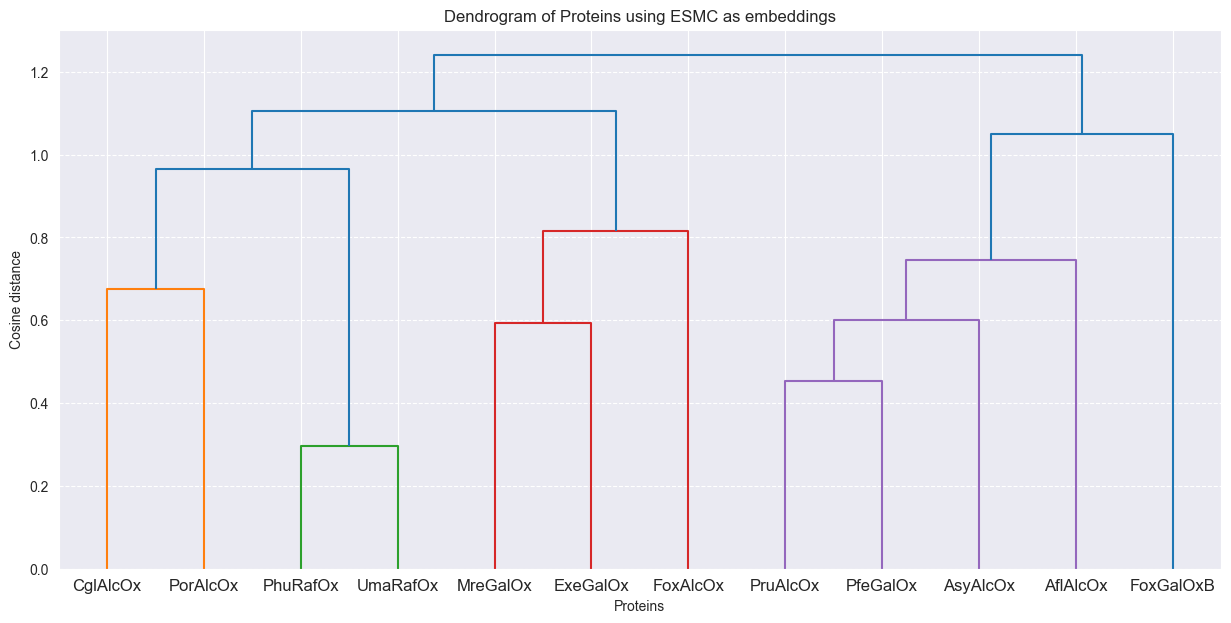

In [71]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

emb_clustering = protein_embs[_C.trilo] #change the protein embeddings HERE
unique_protein_names = df[_C.protein].unique()
protein_embedding_matrix = emb_clustering(unique_protein_names)

# --- Distance matrix --
print(f"Distance matrix: {protein_embedding_matrix.shape}")

# --- Dendogram ---
linked_matrix = linkage(protein_embedding_matrix, method='average', metric='cosine')

plt.figure(figsize=(15, 7))
dendrogram(
    linked_matrix,
    orientation='top',
    labels=unique_protein_names,
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrogram of Proteins using ESMC as embeddings')
plt.ylabel('Cosine distance')
plt.xlabel('Proteins')
plt.grid(axis='y', linestyle='--')
plt.show()

In [72]:
# --- Distance threshold ---
DISTANCE_THRESHOLD = 0.8
protein_cluster_labels = fcluster(linked_matrix, t=DISTANCE_THRESHOLD, criterion='distance')
protein_cluster_labels = protein_cluster_labels - 1

map_protein_to_cluster = dict(zip(unique_protein_names, protein_cluster_labels))
n_found_clusters = len(np.unique(protein_cluster_labels))

print(f"\nFound {n_found_clusters} clusters using {DISTANCE_THRESHOLD}:")
for cluster_id in sorted(np.unique(protein_cluster_labels)):
    members = [name for name, cid in map_protein_to_cluster.items() if cid == cluster_id]
    print(f"Clúster {cluster_id}: {members}")

df['embedding_cluster_id'] = df[_C.protein].map(map_protein_to_cluster)
print("\nColumn 'embedding_cluster_id' added.")

cluster_sizes_rows = (
    df['embedding_cluster_id']
      .value_counts(dropna=False)  # pon dropna=True si quieres ignorar filas no mapeadas
      .sort_index()
      .rename('n_rows')
)
print(cluster_sizes_rows)


Found 6 clusters using 0.8:
Clúster 0: ['PfeGalOx', 'AflAlcOx', 'PruAlcOx', 'AsyAlcOx']
Clúster 1: ['FoxGalOxB']
Clúster 2: ['ExeGalOx', 'MreGalOx']
Clúster 3: ['FoxAlcOx']
Clúster 4: ['UmaRafOx', 'PhuRafOx']
Clúster 5: ['PorAlcOx', 'CglAlcOx']

Column 'embedding_cluster_id' added.
embedding_cluster_id
0    132
1     35
2     51
3     34
4     66
5     67
Name: n_rows, dtype: int64


In [73]:
split_dict = generate_mls_splits(
    df_complete=df,
    col_cluster='embedding_cluster_id',
    col_y='label_4class',
    n_bins_y=6,
    n_splits=10,
    frac_test=0.1,
    frac_val=0.1,
    seed=42
)

print(f"\n¡Splits dict with {len(split_dict)} divisions.")
print(f"Splits keys: {list(split_dict.keys())}")

Generating 10 splits (Test: 10%, Val: 10%)...


KeyError: 'label_4class'

### Sub 3: LOCO Balance Splitting (NEEDS REWORK)

In [74]:
splits = loco_balanced(
    df,
    col_cluster='embedding_cluster_id',
    col_y='binary_label',
    target_clusters=[4, 5],
    col_protein=_C.protein,
    ensure_both_classes=True,      # evita test/val con una sola clase
    threshold=-1.5,
    emit_baseline_variants=False   # puedes dejarlo en False si no quieres *_BASE
)
for k, s in splits.items():
    print(k, len(s.train), len(s.val), len(s.test))

LOCO_intraC4_UmaRafOx_TEST_PhuRafOx_VAL_1 319 32 34
LOCO_intraC4_PhuRafOx_TEST_UmaRafOx_VAL_2 319 34 32


## Sub 2: Classifier models

In [105]:
# ——— Classifiers —————————————————————————
model_makers = {
    'Logistic': lambda: LogisticRegression(
        max_iter=1000, random_state=42
    ),
    'RF':       lambda: RandomForestClassifier(
        n_estimators=100, random_state=42
    ),
    'XGBoost':  lambda: XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    'NGBoost':  lambda: NGBClassifier(random_state=42)
}

# ——— Results and predictions loop ————————
results = []
predict_dict = {}

combined_iterator = itertools.product(
    model_makers.items(),
    split_dict.items(),
    protein_embs.items(),
    mol_embs.items()
)
total_iterations = (
    len(model_makers) *
    len(split_dict) *
    len(protein_embs) *
    len(mol_embs)
)

for (model_name, model_fn), (split_name, split), \
    (p_name, p_emb), (m_name, m_emb) in tqdm(
        combined_iterator,
        total=total_iterations
):
    # Keys for predict_dict
    result_key = (model_name, split_name, p_name, m_name)

    # Info
    info = {
        'model':             model_name,
        'split':             split_name,
        'protein_embeddings':p_name,
        'substrate_embeddings':m_name
    }

    # Splits index
    tr_idx = split.trainval()
    ts_idx = split.test

    # input building
    x_tr = np.concatenate([
        p_emb(proteins[tr_idx]),
        m_emb(mols[tr_idx])
    ], axis=-1)
    x_ts = np.concatenate([
        p_emb(proteins[ts_idx]),
        m_emb(mols[ts_idx])
    ], axis=-1)

    y_tr = y_class[tr_idx]
    y_ts = y_class[ts_idx]

    # train and prediction
    clf     = model_fn()
    clf.fit(x_tr, y_tr)
    y_pred  = clf.predict(x_ts)
    y_proba = clf.predict_proba(x_ts)[:,1]

    # --- SAving metrics in`info` ---
    info |= {
        'auprc' : average_precision_score(y_ts, y_proba),
        'f1_score':  f1_score(y_ts, y_pred, zero_division=0),
        'roc_auc':   roc_auc_score(y_ts, y_proba)
    }

    # --- Saving predictions to expand in rows ---
    predict_dict[result_key] = {
        "y_pred":  y_pred,
        "y_proba": y_proba,
        "y_true":  y_ts,
        "proteins": proteins[ts_idx],
        "mols":     mols[ts_idx]
    }

    results.append(info)

# ——— 4. Saving in rows —————
rows = []
for (model_name, split_name, p_name, m_name), pred in predict_dict.items():
    for prot, mol, yt, yp, yp_p in zip(
        pred["proteins"],
        pred["mols"],
        pred["y_true"],
        pred["y_pred"],
        pred["y_proba"]
    ):
        rows.append({
            "model":           model_name,
            "split":           split_name,
            "protein_name":    prot,
            "substrate_name":  mol,
            "y_true":          int(yt),
            "y_pred":          int(yp),
            "y_proba":         float(yp_p)
        })

# ——— 5. DataFrame Building ————————————————
class_preds_df  = pd.DataFrame(rows)
class_preds_df.to_csv(_C.results_path / 'pred_results' / 'preds_class_data.csv', index=False)
class_results_df = pd.DataFrame(results)
class_results_df.to_csv(_C.results_path / 'pred_results' / 'class_results.csv', index=False)

  0%|          | 0/120 [00:00<?, ?it/s]

/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[iter 0] loss=0.4702 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2090 val_loss=0.0000 scale=2.0000 norm=2.6302
[iter 200] loss=0.1789 val_loss=0.0000 scale=1.0000 norm=1.2705
[iter 300] loss=0.1714 val_loss=0.0000 scale=0.1250 norm=0.1574
[iter 400] loss=0.1702 val_loss=0.0000 scale=0.0156 norm=0.0197
[iter 0] loss=0.4702 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.1920 val_loss=0.0000 scale=2.0000 norm=2.5898
[iter 200] loss=0.1643 val_loss=0.0000 scale=1.0000 norm=1.2594
[iter 300] loss=0.1558 val_loss=0.0000 scale=1.0000 norm=1.2508
[iter 400] loss=0.1513 val_loss=0.0000 scale=0.2500 norm=0.3116
[iter 0] loss=0.4702 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.1922 val_loss=0.0000 scale=2.0000 norm=2.5819
[iter 200] loss=0.1633 val_loss=0.0000 scale=1.0000 norm=1.2562
[iter 300] loss=0.1553 val_loss=0.0000 scale=1.0000 norm=1.2492
[iter 400] loss=0.1513 val_loss=0.0000 scale=0.2500 norm=0.3116
[iter 0] loss=0.4567 val_loss=0.0000 scale=4.0

### Sub 3: Using XGBoost to separate near zero activity from actual activity.

In [88]:
proteins = df[_C.protein].to_numpy(str)
mols     = df[_C.mol].to_numpy(str)
y_cont   = df[_C.label].to_numpy(np.float32)

threshold = -1.6
y_class   = (y_cont > threshold).astype(int)

p_emb = protein_embs['ESMC']
m_emb = mol_embs['RDKit']
x = np.concatenate([p_emb(proteins), m_emb(mols)], axis=-1)

print(f"Shape of matrix: {x.shape}")
print(f"Class distrbution (0: No activity, 1: Activity): \n{pd.Series(y_class).value_counts()}")

all_results = []
out_of_fold_preds = np.zeros(len(df))
for split_name, split in tqdm(split_dict.items(), desc="Processing Folds"):
    train_idx = split.trainval()
    test_idx  = split.test

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y_class[train_idx], y_class[test_idx]

    clf = XGBClassifier(
        n_estimators=500,
        max_depth=8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    clf.fit(x_train, y_train)
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
    y_pred_class = clf.predict(x_test)
    auroc = roc_auc_score(y_test, y_pred_proba)
    all_results.append({
        'fold': split_name,
        'auroc': auroc
    })
    out_of_fold_preds[test_idx] = y_pred_proba

results_df = pd.DataFrame(all_results)
print(results_df)
summary = results_df.agg({
    'auroc': ['mean', 'std']
})
print(summary)
df['xgb_proba'] = out_of_fold_preds
df['xgb_pred']  = (out_of_fold_preds > 0.5).astype(int)

Shape of matrix: (385, 1361)
Class distrbution (0: No activity, 1: Activity): 
1    327
0     58
Name: count, dtype: int64


Processing Folds:   0%|          | 0/10 [00:00<?, ?it/s]

/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [07:34:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [07:34:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [07:34:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/josechemistry/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [07:34:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

            fold     auroc
0   Stratified_1  0.864865
1   Stratified_2  0.838384
2   Stratified_3  0.904040
3   Stratified_4  0.790179
4   Stratified_5  0.951389
5   Stratified_6  0.897321
6   Stratified_7  0.931429
7   Stratified_8  0.945946
8   Stratified_9  0.965714
9  Stratified_10  0.964706
         auroc
mean  0.905397
std   0.058754


# Regression

## Regression splits

In [ ]:
df_positive = df[df['xgb_pred'] == 1].copy()
print(f"Original Dataset: {len(df)} rows.")
print(f"Dataset curated (only positive): {len(df_positive)} rows.")

split_reg = generate_mls_splits(
    df_complete=df_positive,
    col_cluster='embedding_cluster_id',
    col_y=_C.label,
    n_bins_y=5,
    n_splits=10,
    frac_test=0.1,
    frac_val=0.1,
    seed=42
)

Dataset original: 385 rows.
Dataset curated (only positive): 295 rows.
Generating 10 splits (Test: 20%, Val: 10%)...
Created stratification matrix with shape (295, 9) (rows, clusters + y_bins)
  - Generated Stratified_1: Train=208, Val=29, Test=58
  - Generated Stratified_2: Train=208, Val=29, Test=58
  - Generated Stratified_3: Train=208, Val=29, Test=58
  - Generated Stratified_4: Train=208, Val=29, Test=58
  - Generated Stratified_5: Train=208, Val=29, Test=58
  - Generated Stratified_6: Train=207, Val=30, Test=58
  - Generated Stratified_7: Train=208, Val=29, Test=58
  - Generated Stratified_8: Train=208, Val=29, Test=58
  - Generated Stratified_9: Train=206, Val=29, Test=60
  - Generated Stratified_10: Train=205, Val=30, Test=60

DONE! Returning Multilabel Stratified split dictionary.


In [93]:
df_positive = df[df['xgb_pred'] == 1].copy()
splits_regs = loco_balanced(
    df             = df_positive,
    col_cluster    = 'embedding_cluster_id',
    col_y          = None,
    n_splits       = 10,
    frac_test      = 0.10,
    frac_val       = 0.10,
    random_state   = 42,
    n_bins_y       = 5
)

for name, s in splits_class.items():
    print(name, len(s.train), len(s.val), len(s.test))

LOCO_split1 181 22 22
LOCO_split2 181 22 22
LOCO_split3 181 22 22
LOCO_split4 181 22 22
LOCO_split5 181 22 22
LOCO_split6 181 22 22
LOCO_split7 181 22 22
LOCO_split8 181 22 22
LOCO_split9 181 22 22
LOCO_split10 181 22 22


## Baseline models

In [94]:
model_makers = {
    'RF': RandomForestRegressor,
    'Linear': LinearRegression,
    'XGBoost': lambda: XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'NGBoost': lambda: NGBRegressor(random_state=42)
}


proteins = df[_C.protein].to_numpy(str)
mols = df[_C.mol].to_numpy(str)
y = df[_C.label].to_numpy(np.float32)

total_iterations = (
    len(model_makers) *
    len(splits_regs) *
    len(protein_embs) *
    len(mol_embs)
)

combined_iterator = itertools.product(
    model_makers.items(),
    splits_regs.items(),
    protein_embs.items(),
    mol_embs.items()
)
    
results = []
predict_dict = {}
for (model_name, model_fn), (split_name, split), (p_name, p_emb), (m_name, m_emb) in tqdm(
    combined_iterator,
    total=total_iterations):
    result_key = (model_name, split_name, p_name, m_name)
    info = {'model':model_name,
            'split':split_name,
            'protein_embeddings':p_name,
            'substrate_embeddings':m_name}
    train_indexes = split.trainval()
    test_indexes = split.test
    x_train = np.concatenate([p_emb(proteins[train_indexes]), m_emb(mols[train_indexes])], axis=-1)
    x_test = np.concatenate([p_emb(proteins[test_indexes]), m_emb(mols[test_indexes])], axis=-1)
    y_train = y[train_indexes]
    y_test = y[test_indexes]
    model = model_fn()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    info |= evaluate(y_test, y_pred)
    predict_dict[result_key] = {"y_pred": y_pred, "y_test": y_test, "proteins": proteins[split.test], "mols": mols[split.test]}
    results.append(info)

rows = []
for (model_name, split_name, p_name, m_name), pred in predict_dict.items():
    proteins_split = pred["proteins"]
    mols_split     = pred["mols"]
    y_true_split   = pred["y_test"]
    y_pred_split   = pred["y_pred"]
    for prot, mol, yt, yp in zip(proteins_split, mols_split, y_true_split, y_pred_split):
        rows.append({
            "model":          model_name,
            "split":          split_name,
            "protein_name":   prot,
            "substrate_name": mol,
            "y_true":         float(yt),
            "y_pred":         float(yp)
        })

splits_df = pd.DataFrame(rows)
splits_df.to_csv(_C.results_path / 'pred_results' / 'splits_baselines_data.csv', index=False)
results_df = pd.DataFrame(results)
results_df.to_csv(_C.results_path/'pred_results' / 'baseline_results.csv', index=False)

  0%|          | 0/120 [00:00<?, ?it/s]

AttributeError: 'SplitTuple' object has no attribute 'trainval'

# Enzymatch

In [77]:
class MultiTaskEnzymatch(nn.Module):
    def __init__(self, dim_prot, dim_mol, hidden_dim, shared_dim, p_dropout=0.3):
        super().__init__()
        self.proj_p = nn.Sequential(
            nn.Linear(dim_prot, hidden_dim), nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_dim, shared_dim)
        )
        self.proj_m = nn.Sequential(
            nn.Linear(dim_mol, hidden_dim), nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_dim, shared_dim)
        )
        self.reg_head   = nn.Linear(1, 1)
        self.class_head = nn.Linear(1, 1)

    def forward(self, x_p, x_m):
        zp  = F.normalize(self.proj_p(x_p), dim=1)
        zm  = F.normalize(self.proj_m(x_m), dim=1)
        sims = (zp * zm).sum(dim=1, keepdim=True)
        return sims.squeeze(1)  # will be fed into heads externally

In [44]:
# Pytorch metrics
# Reg
def mse_torch(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def r2_torch(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def mae_torch(y_true, y_pred):
    return nn.L1Loss()(y_pred, y_true)

def kendall_tau(y_true, y_pred):
    n = y_true.size(0)
    if n < 2:
        return torch.tensor(0.0, device=y_true.device)
    true_diff = y_true.unsqueeze(1) - y_true.unsqueeze(0)
    pred_diff = y_pred.unsqueeze(1) - y_pred.unsqueeze(0)
    sign_prod = torch.sign(true_diff) * torch.sign(pred_diff)
    return torch.sum(torch.triu(sign_prod, diagonal=1)) / (n * (n - 1) / 2)

# Class
def f1_torch(y_true, y_logits, threshold=0.0):
    y_pred = (y_logits > threshold).float()
    f1 = f1_score(
        y_true.cpu().numpy().astype(int),
        y_pred.cpu().numpy().astype(int)
    )
    return torch.tensor(f1, device=y_true.device)

def auroc_torch(y_true, y_logits):
    auc = roc_auc_score(
        y_true.cpu().numpy().astype(int),
        y_logits.cpu().numpy()
    )
    return torch.tensor(auc, device=y_true.device)

def auprc_torch(y_true, y_logits):
    ap = average_precision_score(
        y_true.cpu().numpy().astype(int),
        y_logits.cpu().numpy()
    )
    return torch.tensor(ap, device=y_true.device)

In [ ]:
# ——— Hyperparam ———
hidden_dim, shared_dim      = 250, 200
lr, weight_decay            = 1e-4, 1e-5
epochs, patience, batch_size = 400, 80, 64
lam, threshold              = 1.0, -1.5
val_frac                   = 0.125

# ——— Data/Devuce ———
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resp_raw = torch.from_numpy(df['log10(Specific Activity)'].values).float().to(device)

prot_emb33 = protein_embs[_C.T33](df[_C.protein].values)
prot_emb6  = protein_embs[_C.T6] (df[_C.protein].values)
prot_embc  = protein_embs[_C.trilo](df[_C.protein].values)
mol_emb    = mol_embs['RDKit'](df[_C.mol].values)

protein_arrays = {
    _C.T33:   torch.from_numpy(prot_emb33).float().to(device),
    _C.T6:    torch.from_numpy(prot_emb6) .float().to(device),
    _C.trilo: torch.from_numpy(prot_embc) .float().to(device),
}
x_mol = torch.from_numpy(mol_emb).float().to(device)

# ——— Result containers ———
all_results    = []
actual_indices = {}

# ——— Embedding per fold index loop ———
for emb_key, xprot in protein_arrays.items():
    print(f"\n===== EMBEDDING: {emb_key} =====")
    for fold_name, split in ((k, s) for k, s in splits.items() if getattr(s, 'val', None) is not None and len(s.val) > 0):
        print(f"\n--- Fold: {fold_name} ---")

        # Index partition
        trainval_idx = split.train
        test_idx     = split.test
        val_idx      = split.val if len(split.val)>0 else []

        if len(val_idx)==0:
            train_idx, val_idx = train_test_split(
                trainval_idx, test_size=val_frac,
                shuffle=True, random_state=int(fold_name.split('_')[1])
            )
        else:
            train_idx = trainval_idx

        actual_indices[(emb_key,fold_name,'train')] = train_idx
        actual_indices[(emb_key,fold_name,'val'  )] = val_idx
        actual_indices[(emb_key,fold_name,'test' )] = test_idx

        # Scaling "y" to [-1,1]
        mn, mx   = resp_raw[train_idx].min(), resp_raw[train_idx].max()
        y_scaled = 2*(resp_raw - mn)/(mx - mn) - 1

        # DataLoaders (4 tensors)
        ds = {}
        for split_name, idxs in [('train',train_idx),('val',val_idx),('test',test_idx)]:
            ds[split_name] = TensorDataset(
                xprot[idxs], x_mol[idxs],
                y_scaled[idxs], resp_raw[idxs]
            )
        loaders = {s: DataLoader(ds[s], batch_size, shuffle=(s=='train'))
                   for s in ds}

        # Model and optimizer
        model     = MultiTaskEnzymatch(xprot.shape[1], x_mol.shape[1],
                                  hidden_dim, shared_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr, weight_decay=weight_decay)
        bce = nn.BCEWithLogitsLoss()
        mse = nn.MSELoss()

        best_val_loss = float('inf')
        patience_ctr  = 0

        # — Training & validation loop —
        for epoch in range(1, epochs+1):
            model.train()
            train_loss = 0.0
            for xb_p, xb_m, yb_scaled, yb_raw in loaders['train']:
                optimizer.zero_grad()
                sims = model(xb_p, xb_m)
                # Heads
                pred_reg     = ((sims + 1)/2)*(mx-mn) + mn  # Rescaling to raw
                logits_class = sims  # using sims as logit
                yb_class     = (yb_raw > threshold).float()
                # Loss
                loss_cl = bce(logits_class, yb_class)
                mask    = yb_class.bool()
                loss_rg = mse(sims[mask], yb_scaled[mask]) if mask.any() else torch.tensor(0., device=device)
                loss    = loss_cl + lam*loss_rg
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb_p.size(0)
            train_loss /= len(loaders['train'].dataset)

            # val
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb_p, xb_m, yv_scaled, yv_raw in loaders['val']:
                    sims = model(xb_p, xb_m)
                    yv_class = (yv_raw > threshold).float()
                    l_cl = bce(sims, yv_class)
                    m_v  = yv_class.bool()
                    l_rg = mse(sims[m_v], yv_scaled[m_v]) if m_v.any() else torch.tensor(0., device=device)
                    val_loss += (l_cl + lam*l_rg).item() * xb_p.size(0)
            val_loss /= len(loaders['val'].dataset)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_ctr  = 0
                torch.save(model.state_dict(),
                           _C.results_path/'enzymatch_results'/'weights per split'/f'best_{emb_key}_{fold_name}.pt')
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            if epoch==1 or epoch%50==0:
                print(f"Ep{epoch:03d} TrainL:{train_loss:.4f} ValL:{val_loss:.4f}")

        # — test —
        model.load_state_dict(torch.load(
            _C.results_path/'enzymatch_results'/'weights per split'/f'best_{emb_key}_{fold_name}.pt',
            map_location=device))
        model.eval()

        # Saving predictions and results
        for split_name, loader in loaders.items():
            all_pr, all_tr = [], []
            cls_logits, cls_true = [], []
            with torch.no_grad():
                for xb_p, xb_m, ys_scaled, ys_raw in loader:
                    sims = model(xb_p, xb_m)
                    pr_raw = ((sims + 1)/2)*(mx-mn) + mn
                    all_pr.append(pr_raw.cpu())
                    all_tr.append(ys_raw.cpu())
                    cls_logits.append(sims.cpu())
                    cls_true.append((ys_raw>threshold).float().cpu())
            pr = torch.cat(all_pr).numpy()
            tr = torch.cat(all_tr).numpy()
            lg = torch.cat(cls_logits).numpy()
            yt = torch.cat(cls_true).numpy().astype(int)

            # regression metrics
            mse_v = ((tr-pr)**2).mean()
            ssr   = ((tr-pr)**2).sum()
            sst   = ((tr-tr.mean())**2).sum()
            r2_v  = 1 - ssr/sst
            mae_v = abs(tr-pr).mean()
            kt_v  = kendall_tau(torch.from_numpy(tr).to(device),
                                torch.from_numpy(pr).to(device)).item()

            # classif metrics
            f1_v   = f1_score(yt, (lg>0).astype(int))
            auc_v  = roc_auc_score(yt, lg)
            ap_v   = average_precision_score(yt, lg)

            all_results.append({
                'embedding': emb_key,
                'fold':      fold_name,
                'split':     split_name,
                'mse':       mse_v,
                'r2':        r2_v,
                'mae':       mae_v,
                'kendall':   kt_v,
                'f1':        f1_v,
                'auroc':     auc_v,
                'auprc':     ap_v
            })

# ——— tidying ———
df = pd.DataFrame(all_results)
print(df.pivot_table(
    index=['embedding','fold'],
    columns='split',
    values=['mse','r2','mae','kendall','f1','auroc','auprc'],
    aggfunc='first'
))

summary = df.groupby(['embedding','split']).agg(
    mse_mean     = ('mse','mean'),
    mse_std      = ('mse','std'),
    r2_mean      = ('r2','mean'),
    r2_std       = ('r2','std'),
    mae_mean     = ('mae','mean'),
    mae_std      = ('mae','std'),
    kendall_mean = ('kendall','mean'),
    kendall_std  = ('kendall','std'),
    f1_mean      = ('f1','mean'),
    f1_std       = ('f1','std'),
    auroc_mean   = ('auroc','mean'),
    auroc_std    = ('auroc','std'),
    auprc_mean   = ('auprc','mean'),
    auprc_std    = ('auprc','std')
).reset_index()

print(summary)
df.to_csv(_C.results_path/'enzymatch_results'/'by_fold.csv', index=False)
summary.to_csv(_C.results_path/'enzymatch_results'/'summary.csv', index=False)


===== EMBEDDING: ESM2_T33 =====

--- Fold: LOCO_intraC4_UmaRafOx_TEST_PhuRafOx_VAL_1 ---
Ep001 TrainL:0.8253 ValL:0.9150
Ep050 TrainL:0.6755 ValL:1.2531
Early stopping at epoch 81

--- Fold: LOCO_intraC4_PhuRafOx_TEST_UmaRafOx_VAL_2 ---
Ep001 TrainL:0.8462 ValL:0.9346
Ep050 TrainL:0.6729 ValL:1.1200
Early stopping at epoch 81

===== EMBEDDING: ESM2_T6 =====

--- Fold: LOCO_intraC4_UmaRafOx_TEST_PhuRafOx_VAL_1 ---
Ep001 TrainL:0.8636 ValL:1.0149
Ep050 TrainL:0.6765 ValL:1.4950
Early stopping at epoch 81

--- Fold: LOCO_intraC4_PhuRafOx_TEST_UmaRafOx_VAL_2 ---
Ep001 TrainL:0.8483 ValL:0.9630
Ep050 TrainL:0.6747 ValL:1.2428
Early stopping at epoch 81

===== EMBEDDING: ESMC =====

--- Fold: LOCO_intraC4_UmaRafOx_TEST_PhuRafOx_VAL_1 ---
Ep001 TrainL:0.8193 ValL:0.9110
Ep050 TrainL:0.6715 ValL:1.3749
Early stopping at epoch 81

--- Fold: LOCO_intraC4_PhuRafOx_TEST_UmaRafOx_VAL_2 ---
Ep001 TrainL:0.8130 ValL:0.9673
Ep050 TrainL:0.6724 ValL:1.0749
Early stopping at epoch 82
                  

In [79]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionEnzymatch(nn.Module):
    """
    Predice un escalar en [-1, 1] a partir del coseno entre las proyecciones
    de proteína y molécula. Úsala con y_scaled en [-1,1].
    """
    def __init__(self, dim_prot, dim_mol, hidden_dim=512, shared_dim=128, p_dropout=0.3):
        super().__init__()
        self.proj_p = nn.Sequential(
            nn.Linear(dim_prot, hidden_dim), nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_dim, shared_dim)
        )
        self.proj_m = nn.Sequential(
            nn.Linear(dim_mol, hidden_dim), nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_dim, shared_dim)
        )

    def forward(self, x_p, x_m):
        zp = F.normalize(self.proj_p(x_p), dim=1)  # (B, d)
        zm = F.normalize(self.proj_m(x_m), dim=1)  # (B, d)
        yhat = (zp * zm).sum(dim=1)                # (B,) coseno ∈ [-1, 1]
        return yhat

In [80]:
# ——— Hyperparam ———
hidden_dim, shared_dim       = 250, 200
lr, weight_decay             = 1e-4, 1e-5
epochs, patience, batch_size = 400, 80, 64
val_frac                     = 0.125

# ——— Data/Device ———
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resp_raw = torch.from_numpy(df['log10(Specific Activity)'].values).float().to(device)

prot_emb33 = protein_embs[_C.T33](df[_C.protein].values)
prot_emb6  = protein_embs[_C.T6] (df[_C.protein].values)
prot_embc  = protein_embs[_C.trilo](df[_C.protein].values)
mol_emb    = mol_embs['RDKit'](df[_C.mol].values)

protein_arrays = {
    _C.T33:   torch.from_numpy(prot_emb33).float().to(device),
    _C.T6:    torch.from_numpy(prot_emb6) .float().to(device),
    _C.trilo: torch.from_numpy(prot_embc) .float().to(device),
}
x_mol = torch.from_numpy(mol_emb).float().to(device)

# ——— Result containers ———
all_results    = []
actual_indices = {}

# ——— Embedding per fold index loop ———
for emb_key, xprot in protein_arrays.items():
    print(f"\n===== EMBEDDING: {emb_key} =====")
    # solo folds con validación
    for fold_name, split in ((k, s) for k, s in splits.items() if getattr(s, 'val', None) is not None and len(s.val) > 0):
        print(f"\n--- Fold: {fold_name} ---")

        # Index partition
        trainval_idx = np.asarray(split.train, dtype=int)
        test_idx     = np.asarray(split.test,  dtype=int)
        val_idx      = np.asarray(split.val,   dtype=int)

        if val_idx.size == 0:
            # fallback (no debería ocurrir por el filtro de arriba)
            train_idx, val_idx = train_test_split(
                trainval_idx, test_size=val_frac,
                shuffle=True, random_state=0
            )
        else:
            train_idx = trainval_idx

        actual_indices[(emb_key,fold_name,'train')] = train_idx
        actual_indices[(emb_key,fold_name,'val'  )] = val_idx
        actual_indices[(emb_key,fold_name,'test' )] = test_idx

        # Scaling "y" to [-1,1] con protección numérica
        mn, mx = resp_raw[train_idx].min(), resp_raw[train_idx].max()
        den    = float(max((mx - mn).item() if torch.is_tensor(mx) else (mx - mn), 1e-8))
        y_scaled = 2*(resp_raw - mn)/den - 1

        # DataLoaders (4 tensores)
        ds = {}
        for split_name, idxs in [('train',train_idx),('val',val_idx),('test',test_idx)]:
            ds[split_name] = TensorDataset(
                xprot[idxs], x_mol[idxs],
                y_scaled[idxs], resp_raw[idxs]
            )
        loaders = {s: DataLoader(ds[s], batch_size, shuffle=(s=='train')) for s in ds}

        # Model and optimizer (solo regresión)
        model     = RegressionEnzymatch(xprot.shape[1], x_mol.shape[1], hidden_dim, shared_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        mse       = nn.MSELoss()  # (si tu cola es pesada, prueba SmoothL1Loss(beta=0.2))

        best_val_loss = float('inf')
        patience_ctr  = 0

        # — Training & validation loop —
        for epoch in range(1, epochs+1):
            model.train()
            train_loss = 0.0
            for xb_p, xb_m, yb_scaled, _yb_raw in loaders['train']:
                optimizer.zero_grad()
                pred_scaled = model(xb_p, xb_m)              # (B,)
                loss = mse(pred_scaled, yb_scaled)           # solo regresión en [-1,1]
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb_p.size(0)
            train_loss /= len(loaders['train'].dataset)

            # val
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb_p, xb_m, yv_scaled, _yv_raw in loaders['val']:
                    pred_scaled = model(xb_p, xb_m)
                    val_loss += mse(pred_scaled, yv_scaled).item() * xb_p.size(0)
            val_loss /= len(loaders['val'].dataset)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_ctr  = 0
                torch.save(model.state_dict(),
                           _C.results_path/'enzymatch_results'/'weights per split'/f'best_{emb_key}_{fold_name}.pt')
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            if epoch==1 or epoch%50==0:
                print(f"Ep{epoch:03d} TrainL:{train_loss:.4f} ValL:{val_loss:.4f}")

        # — test —
        model.load_state_dict(torch.load(
            _C.results_path/'enzymatch_results'/'weights per split'/f'best_{emb_key}_{fold_name}.pt',
            map_location=device))
        model.eval()

        # Saving predictions and results
        for split_name, loader in loaders.items():
            all_pr_raw, all_tr_raw = [], []
            with torch.no_grad():
                for xb_p, xb_m, _ys_scaled, ys_raw in loader:
                    pred_scaled = model(xb_p, xb_m)
                    pr_raw = ((pred_scaled + 1)/2)*den + mn      # back to raw
                    all_pr_raw.append(pr_raw.cpu())
                    all_tr_raw.append(ys_raw.cpu())

            pr = torch.cat(all_pr_raw).numpy()
            tr = torch.cat(all_tr_raw).numpy()

            # regression metrics
            mse_v = ((tr-pr)**2).mean()
            ssr   = ((tr-pr)**2).sum()
            sst   = ((tr-tr.mean())**2).sum()
            r2_v  = 1 - ssr/sst if sst > 0 else 0.0
            mae_v = np.abs(tr-pr).mean()
            kt_v  = kendall_tau(torch.from_numpy(tr).to(device),
                                torch.from_numpy(pr).to(device)).item()

            all_results.append({
                'embedding': emb_key,
                'fold':      fold_name,
                'split':     split_name,
                'mse':       mse_v,
                'r2':        r2_v,
                'mae':       mae_v,
                'kendall':   kt_v,
            })

# ——— tidying ———
df_res = pd.DataFrame(all_results)
print(df_res.pivot_table(
    index=['embedding','fold'],
    columns='split',
    values=['mse','r2','mae','kendall'],
    aggfunc='first'
))

summary = df_res.groupby(['embedding','split']).agg(
    mse_mean     = ('mse','mean'),
    mse_std      = ('mse','std'),
    r2_mean      = ('r2','mean'),
    r2_std       = ('r2','std'),
    mae_mean     = ('mae','mean'),
    mae_std      = ('mae','std'),
    kendall_mean = ('kendall','mean'),
    kendall_std  = ('kendall','std')
).reset_index()

print(summary)
df_res.to_csv(_C.results_path/'enzymatch_results'/'by_fold.csv', index=False)
summary.to_csv(_C.results_path/'enzymatch_results'/'summary.csv', index=False)

KeyError: 'log10(Specific Activity)'

In [90]:
rows = []
for (fold_name, emb_key, split_name), y_true_array in true_dict.items():
    y_pred_array = preds_dict[(fold_name, emb_key, split_name)] #array predictions
    #Retrieve index list for this dataframe per fold and per split:
    idxs = actual_indices[(fold_name, split_name)]
    
    #WAlk trough each example in this set:
    for i, idx in enumerate(idxs):
        rows.append({
            'fold':      fold_name,                 # e.g. "Random_1"
            'embedding': emb_key,                   # e.g. "ESM2_T33"
            'split':     split_name,                # "train" / "val" / "test"
            'protein':   df.loc[idx, _C.protein],
            'mol':       df.loc[idx, _C.mol],
            'y_true':    float(y_true_array[i]),
            'y_pred':    float(y_pred_array[i])
        })

# Turn to dataframe and save it
clip_preds = pd.DataFrame(rows)
clip_preds.to_csv(_C.results_path / 'CLIP results' / 'clip_predictions.csv', index=False)